### In this notebook, we'll outline a process to figure out the optimal no of trees required in a Random Forest,
### without training the model again and again. I learnt this approach in the [Competitive Data Science](https://www.coursera.org/learn/competitive-data-science/home/welcome) course 
### on Coursera, and found it to be a pretty useful trick.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
import fastai_structured as fs  ## For handling categorical variables

%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
X = pd.read_csv("/kaggle/input/titanic/train.csv")
X.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


#### Creating training and validation sets
Handling categorical data using fastai v0.7 functions which are added as a utility script

In [3]:
fs.train_cats(X)  ## Converts strings to categorical variables
X, y, nas = fs.proc_df(X, 'Survived')
X_train, X_val, y_train, y_val = train_test_split(X, y)
print(X_train.shape)
print(X_val.shape)

(668, 12)
(223, 12)


In [4]:
rf = RandomForestClassifier(n_estimators=500, max_depth=3, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

#### Get predictions for each tree separately

In [5]:
predictions = []
for tree in rf.estimators_:
    predictions.append(tree.predict_proba(X_val)[None, :])

In [6]:
predictions = np.vstack(predictions)
cum_mean = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[0] + 1)[:, None, None]

#### Get accuracy scores for each of the n_estimators value

In [7]:
scores = []
for pred in cum_mean:
    scores.append(accuracy_score(y_val, np.argmax(pred, axis=1)))

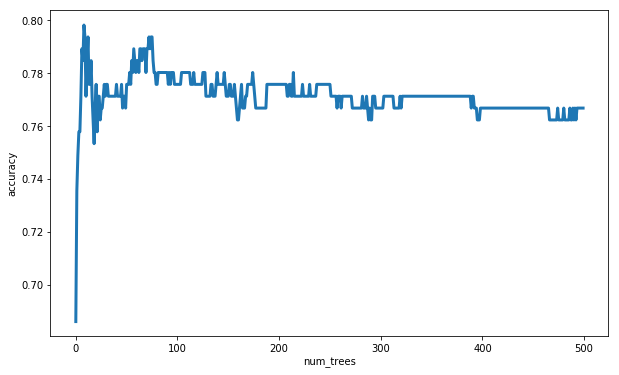

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(scores, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('accuracy');

### We see that around 150 trees are enough to get a good accuracy and 
### there is not really any payoff for adding new trees in the forest after that